# E-Commerce Retail Analysis

This notebook analyzes the data gathered from a UK-based online retailer. They primarily sell unique all-occasion gifts to customers, many of which are wholesalers. Data was collected between 1/12/2010 and 9/12/2019 and is stored on an excel file.

We will be investigating Stock Code "85123A", which are small tea-sized candle holders.

The data is hosted on UCI's Machine Learning Repository at: [link](https://archive.ics.uci.edu/ml/datasets/online+retail#)

# 1. Creating the landscape
## Import libraries

In [1]:
# Math and Data
import numpy as np
import pandas as pd

# Set the output of pandas dataframes to display up to 100 columns
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

# Misc
from IPython.display import display      # display function prints pandas table instead of text; sub for print()
import copy
import datetime
from tqdm import tqdm

## Load the data

In [2]:
filepath = 'C:/Users/moogl/Desktop/Python_SQL_Material/Python/Projects/Ecommerce/'

data = pd.read_csv(filepath + 'Online Retail.csv')

print(f'There are {data.shape[0]} rows and {data.shape[1]} columns.')
data.head()

There are 541909 rows and 8 columns.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 2. Exploring the Data
## Check to see if there's any missing data

In [3]:
def percent_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()

    # instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    return df_NA

NA = percent_NA(data)
NA

,Number of NA,Percent NA
CustomerID,135080,24.93
Description,1454,0.27
Country,0,0.00
UnitPrice,0,0.00
InvoiceDate,0,0.00
Quantity,0,0.00
StockCode,0,0.00
InvoiceNo,0,0.00


The missing data is mostly in the CustomerID column with some in the Description. There's an issue when we have no customer info for nearly 25% of our transactions. For investigations that require CustomerID and full descriptions, dropping these values would be a valid choice.

## Let's look at items that appear a lot in the data

In [4]:
# Use the groupby method
data_gbSize = data.groupby(data['StockCode']).size().sort_values(ascending=False)
data_gbSize.head()

StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
dtype: int64

In [5]:
for item in data_gbSize.index[:5]:
    display(data.loc[ data['StockCode']==item ].head(1))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
880,536477,22423,REGENCY CAKESTAND 3 TIER,16,12/1/2010 12:27,10.95,16210.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
177,536386,85099B,JUMBO BAG RED RETROSPOT,100,12/1/2010 9:57,1.65,16029.0,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
5535,536864,47566,PARTY BUNTING,1,12/3/2010 11:27,9.32,NaN,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
93,536378,20725,LUNCH BAG RED RETROSPOT,10,12/1/2010 9:37,1.65,14688.0,United Kingdom


In [6]:
# This is another way to do a groupby using size aggregation
stockcode_cts = data['StockCode'].value_counts().sort_values(ascending=False)
stockcode_cts.iloc[:5]

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: StockCode, dtype: int64

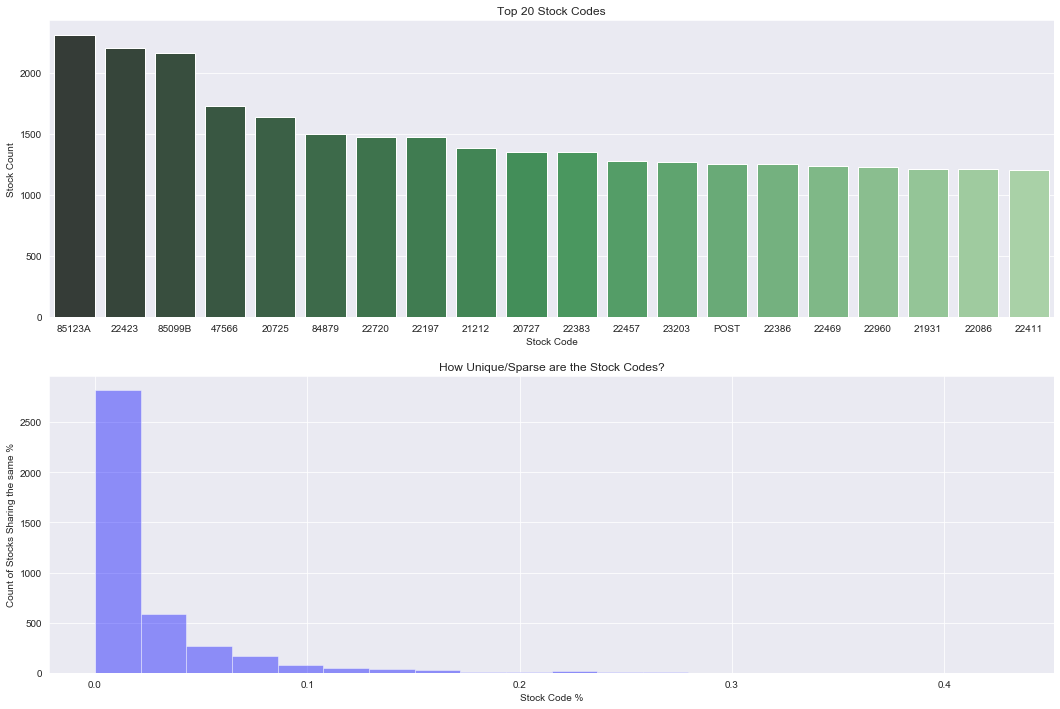

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(18,12))

# Subplot 1
sns.barplot(x=stockcode_cts.iloc[:20].index,
            y=stockcode_cts.iloc[:20].values,
            ax=ax[0], palette='Greens_d')
ax[0].set_xlabel('Stock Code')
ax[0].set_ylabel('Stock Count')
ax[0].set_title('Top 20 Stock Codes')

# Subplot 2
sns.distplot(np.round(stockcode_cts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Blue")
ax[1].set_title("How Unique/Sparse are the Stock Codes?")
ax[1].set_xlabel("Stock Code %")
ax[1].set_ylabel("Count of Stocks Sharing the same %");

The second graph indicates that there is a high volume of stock codes in the data that constitute a small part of all the data. This means that the retailer sells __many different__ products. This may not explain the whole picture. For example, the seller may sell many different types of pencils, each with a different code.

For now, let's look at stock code 85123A which as the most entries in the data with 2313 transactions, so let's look at the time-series for this item.

# 3. Data Processing
## Change InvoiceDate to a datetime variable

In [8]:
def process_dates(data, col_name):
    data[col_name] = data.index.map(lambda x: data[col_name][x].split()[0])   # x is the columnar object before .map()
    data[col_name] = pd.to_datetime(data[col_name])
    return data
    
data = process_dates(data, 'InvoiceDate')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


# 4. Time series data analysis

Composed of 4 types of observations:

> 1. Trend - is the data trending upwards or downwards?
> 2. Seasonality - do values go up/down during a specific period of time?
> 3. Irregularity - noise in the data (aka residual)
> 4. Cyclic - longer timescale compared to seasonality. May see trends happening every 2 years etc.

## Investigate "White hanging heart t-light holder" 

In [9]:
df_tlight = data.loc[ data['StockCode']=='85123A' ]
df_tlight = df_tlight.sort_values(by=['InvoiceDate'])
df_tlight.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
3062,536594,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.95,15235.0,United Kingdom
2998,536592,85123A,WHITE HANGING HEART T-LIGHT HOLDER,9,2010-12-01,5.91,NaN,United Kingdom


In [10]:
# Group by the invoice date and sum the values in the resulting columns
tlight_gbSize = df_tlight.groupby(df_tlight['InvoiceDate']).sum()
tlight_gbSize.head()

,Quantity,UnitPrice,CustomerID
InvoiceDate,,,
2010-12-01,454,52.47,239622.0
2010-12-02,309,50.85,329665.0
2010-12-03,25,23.61,94008.0
2010-12-05,198,37.55,212423.0
2010-12-06,161,49.38,172305.0


C:\Users\moogl\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


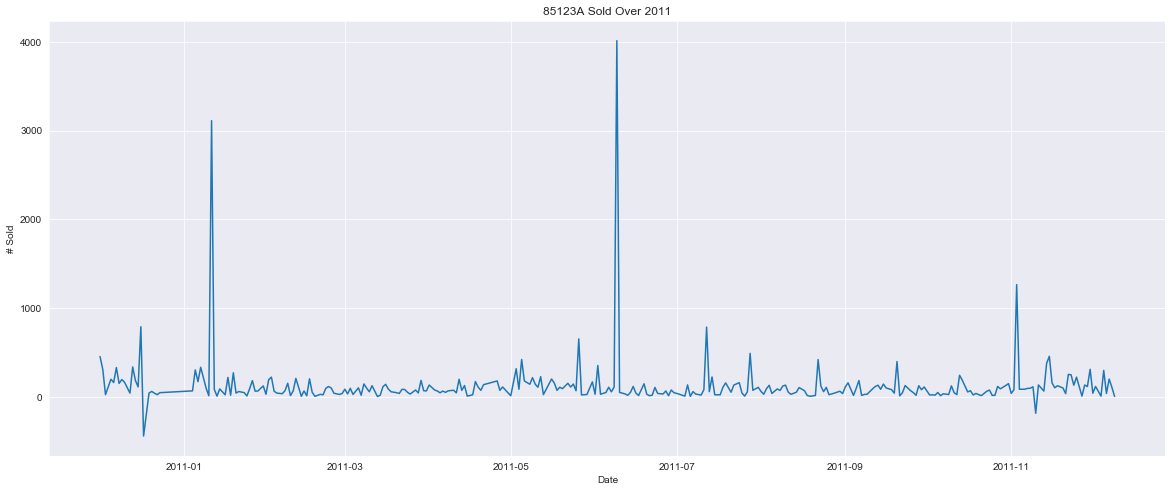

In [11]:
t = tlight_gbSize.index
y = tlight_gbSize['Quantity']

# Plot
fig, ax = plt.subplots(figsize=(20, 8))

plt.plot(t, y)

ax.set_xlabel('Date')
ax.set_ylabel('# Sold')
ax.set_title('85123A Sold Over 2011');

It seems like we have some huge outliers. We can use Seaborn's boxplot to visualize the outliers:

Text(0.5, 1.0, '')

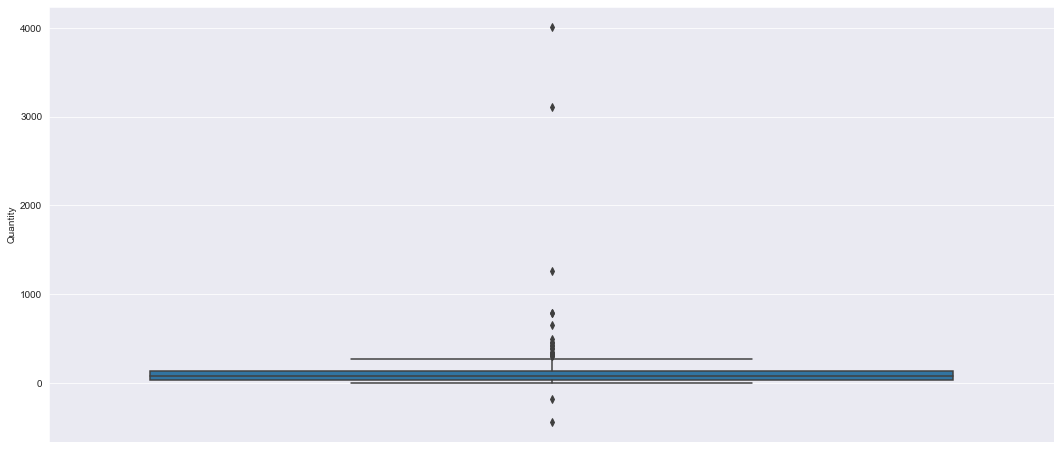

In [12]:
fig = plt.figure(figsize=(18,8))
sns.boxplot(y, orient='v')
plt.title('')

It seems like we have a lot of outliers. To make our investigation more reliable, we'll remove the 5% and 95% percentile from the data and plot the time-series again.

In [13]:
low_quantity = y.quantile(0.05)
high_quantity = y.quantile(0.95)

print(f'The 5% percentile is: {low_quantity}\nThe 95% percentile is: {high_quantity}')

The 5% percentile is: 11.200000000000001
The 95% percentile is: 332.40000000000003


In [14]:
# Keep track of the original amount of data
data_ct_before = y.shape[0]

# Remove outliers
y = y.loc[ (y >= low_quantity) & (y <= high_quantity) ]

# Print the number of data points removed
print(f'The number of outliers removed: {data_ct_before - y.shape[0]}')

The number of outliers removed: 32


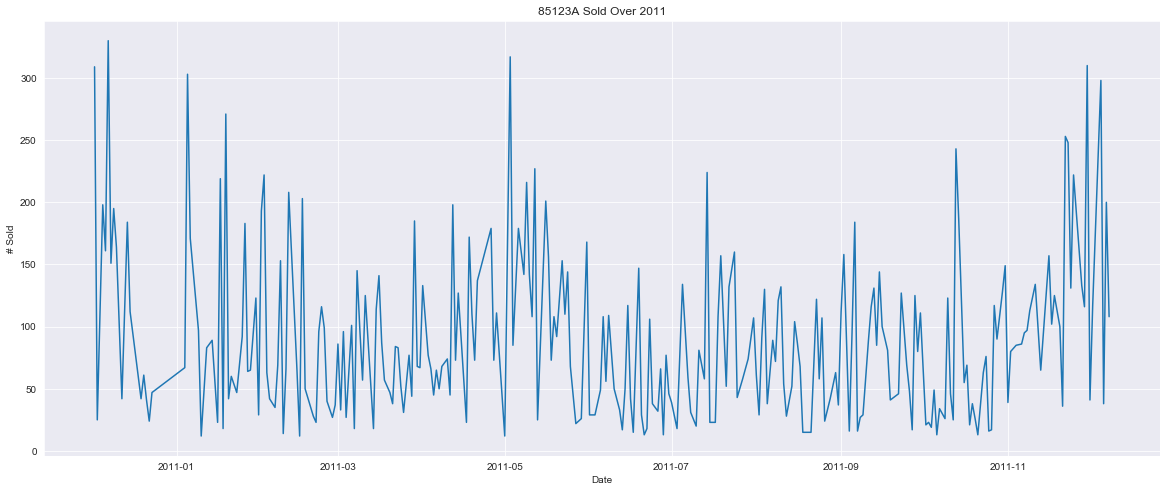

In [15]:
t = y.index

# Plot again without the outliers
fig, ax = plt.subplots(figsize=(20, 8))

plt.plot(t, y)
ax.set_xlabel('Date')
ax.set_ylabel('# Sold')
ax.set_title('85123A Sold Over 2011');

### Calculate the 10 day moving average for the number of product "85123A" and its standard deviation

In [16]:
ma = y.rolling(10).mean()
msd = y.rolling(10).std()

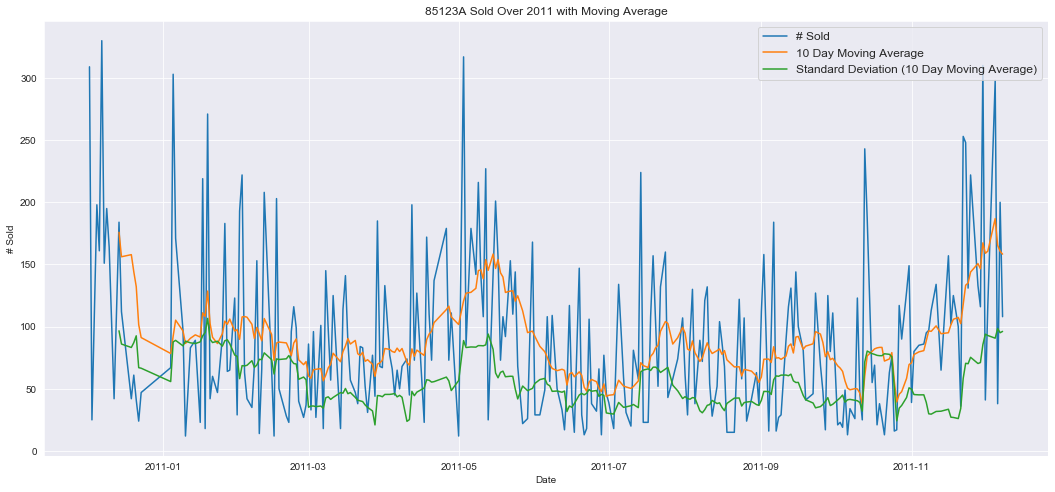

In [17]:
# Set x-axis as Date
t = y.index

# Plot again without the outliers
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(t, y, label='# Sold')
ax.plot(t, ma, label='10 Day Moving Average')
ax.plot(t, msd, label='Standard Deviation (10 Day Moving Average)')

ax.set_xlabel('Date')
ax.set_ylabel('# Sold')
ax.set_title('85123A Sold Over 2011 with Moving Average')
ax.legend(fontsize=12, loc='upper right');

The moving average plotted above helps visualize the trend of the data. Is the trend increasing or decreasing over the 2011 period? It appears that the number of products sold remains relatively neutral over the 2011 period. Visually, this means that the data could be stationary, but we can't really tell for sure.

Stationarity implies that the statistical properties of the data doesn't change over time. In other words, both the mean and variance are constant and the autocovariance doesn't depend on time. Stationarity can also be evaluated by an ADCF Test. Stationary data is one that has reduced noise and no trends/seasonality compared to non-stationary data, which is important for many forecasting algorithms performance-wise.

## Diagnosing stationarity

Let's first look at the histogram of the data to see how meaningful the mean and standard deviation. A normal distribution provides great power for the mean and standard deviation.

Thanks to Jason for the blog post on stationarity: https://machinelearningmastery.com/time-series-data-stationary-python/

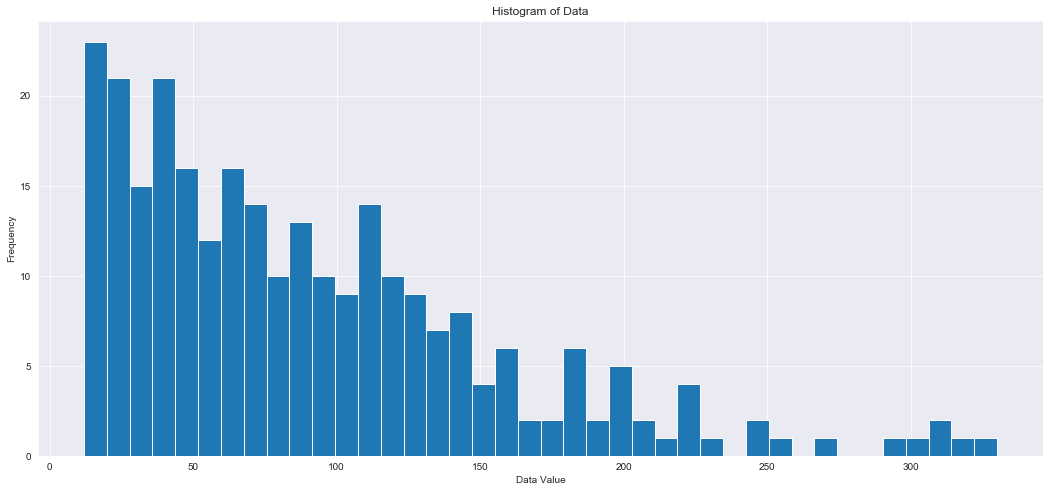

In [18]:
# Plot histogram
fig = plt.figure(figsize=(18,8))

plt.hist(y, bins=40)
plt.xlabel('Data Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data');

The data does not follow a normal distribution, but looks more like a log distribution. This means that we can't necessarily rely on the mean and standard deviation of the current data.

What we can do however, is to transform the data by taking the log of it.

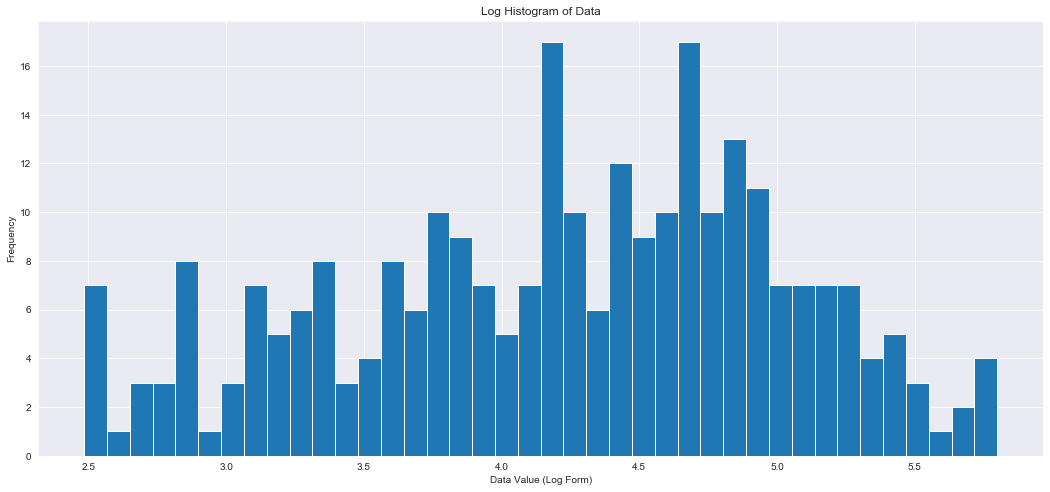

In [19]:
# Plot log histogram
fig = plt.figure(figsize=(18,8))

plt.hist(np.log(y), bins=40)         # Call np.exp() to undo the np.log() transform
plt.xlabel('Data Value (Log Form)')
plt.ylabel('Frequency')
plt.title('Log Histogram of Data');

Now that we applied the log transform, we see that the histogram looks more like a normal distribution which means we can use the mean and standard deviation values with greater confidence in calculating stationarity.

Let's look at what the log of the data plot looks like now.

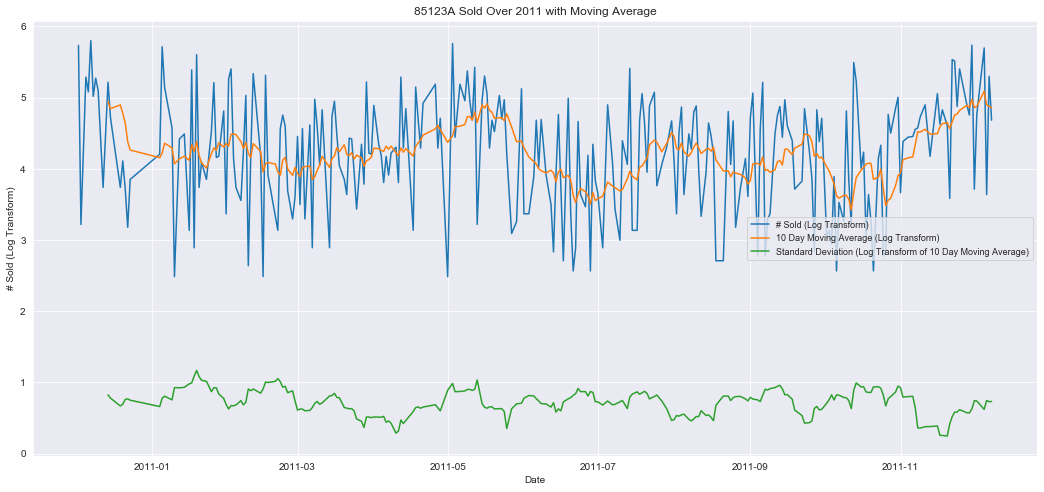

In [20]:
ma = np.log(y).rolling(10).mean()
msd = np.log(y).rolling(10).std()

# Plot the log(data)
fig, ax = plt.subplots(figsize=(18,8))

ax.plot(t, np.log(y), label='# Sold (Log Transform)')
ax.plot(t, ma, label='10 Day Moving Average (Log Transform)')
ax.plot(t, msd, label='Standard Deviation (Log Transform of 10 Day Moving Average)')

ax.set_xlabel('Date')
ax.set_ylabel('# Sold (Log Transform)')
ax.set_title('85123A Sold Over 2011 with Moving Average')
ax.legend(fontsize=9, loc='right')

#ax[1].set_xlabel('Date')
#ax[1].set_ylabel('SD (Log Transform of 10 Day Moving Average)')
#ax[1].set_title('Standard Deviation (Log Transform of 10 Day Moving Average)')
#ax[1].legend(fontsize=12);

The log transform of the data reveals that its 10 day moving average remains stable, implying that it may be stationary.

Another way to evaluate stationarity is to look at the autocorrelation plot, which is more robust.

### Using autocorrelation to diagnose stationarity

Description of autocorrelation taken from my other notebook titled "Tutorial - Unsupervised Clustering using a Mixture Model with PyMC3":

"Autocorrelation is a metric between -1 and 1 that measures how related is the data to itself. This is done by comparing the correlation of the data with a time-lagged version of the same data. When data is highly autocorrelated, we can predict with relative ease the value right before or after. For data that is not autocorrelated, it is much harder to predict because there is no inherent pattern to the data".

If the data is not stationary, the data once plotted in an autocorrelation plot (aka correlogram), will show that as we increase $k$ (lag), the data will slope down towards a value of zero. For stationary data, the values will not slope down to zero and may stay at a higher value.

Thanks to Shay as well for suggesting autocorrelation in dealing with stationarity: https://www.kdnuggets.com/2019/08/stationarity-time-series-data.html

In [21]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

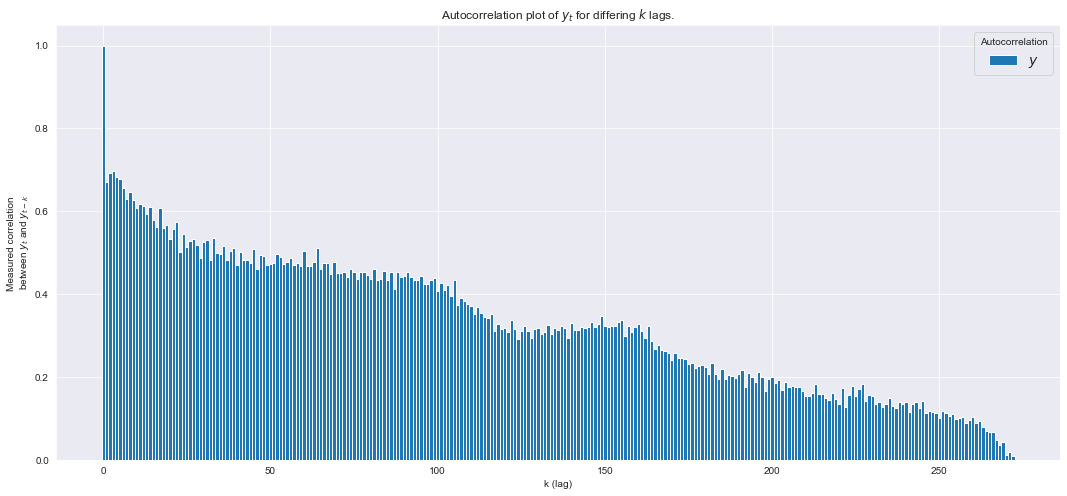

In [22]:
# Create x values
x = np.arange(0, len(t))

# Plot autocorrelation
fig = plt.figure(figsize=(18, 8))

plt.bar(x, autocorr(y),
        width=1,
        label='$y$')

plt.xlabel('k (lag)')
plt.ylabel('Measured correlation \nbetween $y_t$ and $y_{t-k}$')
plt.title("Autocorrelation plot of $y_t$ for differing $k$ lags.")
plt.legend(title='Autocorrelation', fontsize=14);

### How to make your data not autocorrelated
This can be done by standardizing the data, which is rescaling the data to have a mean of 0 and a unit variance of 1. This is not to be confused by normalization, which rescales the data to be within 0 and 1.

In [23]:
# Remove mean and scale to unit variance function
def standardize(data):
    """
    Standardizes the data by subtracting the data's mean from all the data points and scales to unit variance function.
    
    Code provided by: "https://stackoverflow.com/questions/31152967/normalise-2d-numpy-array-zero-mean-unit-variance"
    
    Parameters
    ----------
    data : data
    """
    standardized = (data - data.mean(axis=0)) / data.std(axis=0)
    return standardized

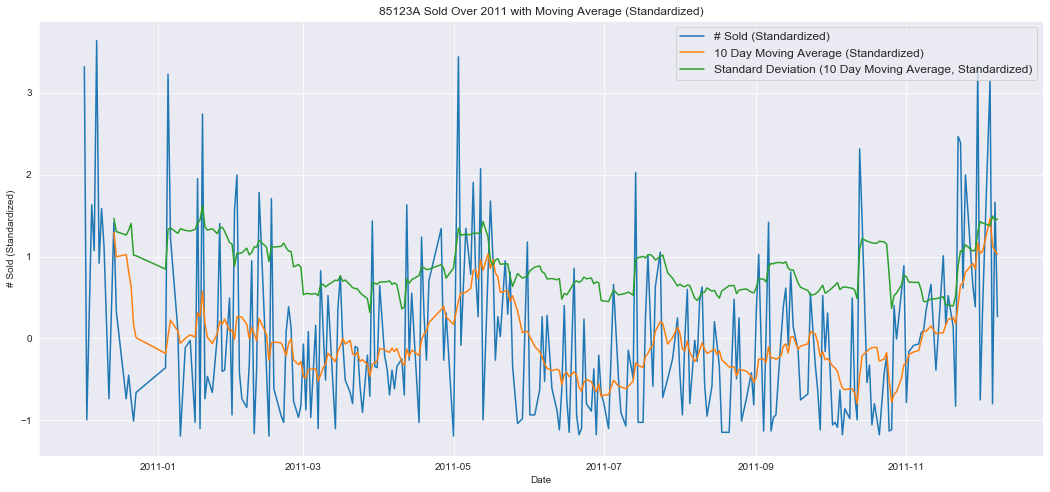

In [24]:
ma = standardize(y).rolling(10).mean()
msd = standardize(y).rolling(10).std()

# Plot the standardized data
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(t, standardize(y), label='# Sold (Standardized)')
ax.plot(t, ma, label='10 Day Moving Average (Standardized)')
ax.plot(t, msd, label='Standard Deviation (10 Day Moving Average, Standardized)')

ax.set_xlabel('Date')
ax.set_ylabel('# Sold (Standardized)')
ax.set_title('85123A Sold Over 2011 with Moving Average (Standardized)')
ax.legend(fontsize=12);

### How does standardizing the data effect the autocorrelation plot?

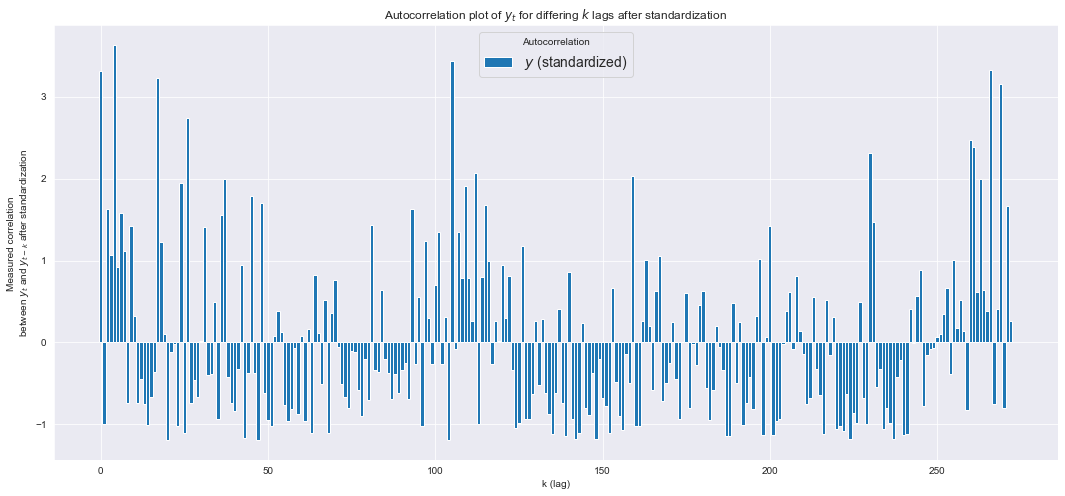

In [25]:
# Create x values
x = np.arange(0, len(t))

# Plot autocorrelation after standardization
fig = plt.figure(figsize=(18, 8))

plt.bar(x, standardize(y),
        width=1,
        label='$y$ (standardized)')

plt.xlabel('k (lag)')
plt.ylabel('Measured correlation \nbetween $y_t$ and $y_{t-k}$ after standardization')
plt.title("Autocorrelation plot of $y_t$ for differing $k$ lags after standardization")
plt.legend(title='Autocorrelation', fontsize=14);

Awesome! It looks like the autocorrelation plot after standardization removed the autocorrelation for the most part. Now we can be more sure that the data is now stationary. However, this doesn't help change the overall trend of the data.

We can now try to run some prediction models on the data to predict the amount of product "85123A" will sell over the next few months.

ARIMA models can account for stationarity with by setting calling one of its parameters, transparams, to be true.

# 5. Prediction Model

## Forecasting with the ARIMA model

ARIMA stands for __A__uto __R__egressive __I__ntegrated __M__oving __A__verage. It is a time-series forecasting method that helps predict future data values.

There are three integer parameters to pass in the model $p$, $d$ and $q$:

> $p$: This value deals with autoregression, which takes into account past values in the data. If the past values are similar to each other, it will be more likely that the next value will also be similar.

> $d$: This incorporates integration. The higher the value, the more past data points it uses to subtract from the current value. If the past values show little difference in their values, the current value would be similar.

> $q$: This value incorporates moving average in the model. It defines the error of the model as a linear combination of past data points.

There are a couple ways to sample when forecasting. Using:

> 1. In-sample forecast: using the fitted model to forecast samples it has seen.
> 2. Out-of-sample forecast: using the fitted model to forecast samples it hasn't seen.

Out-of-sample forecasting will be focused on.

### 1st way (without walk forward validation and transformations)

In [26]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [27]:
# Fit ARIMA model to the non-standardized data
model = ARIMA(endog = y, order=(5,1,0))
results = model.fit()
results.summary()

C:\Users\moogl\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\moogl\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.Quantity   No. Observations:                  272
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1519.054
Method:                       css-mle   S.D. of innovations             64.300
Date:                Wed, 25 Sep 2019   AIC                           3052.109
Time:                        18:02:58   BIC                           3077.349
Sample:                             1   HQIC                          3062.242
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1737      1.024     -0.170      0.865      -2.181       1.834
ar.L1.D.Quantity    -0.9418      0.060    -15.594      0.000      -1.060      -0.823
ar.L2.D.Quantity    -0.7825      0.080     -9.766      0.000      -0.940      -0.625
ar.L3.D.Quantity    -0.5812      0.087     -6.692      0.000      -0.751      -0.411
ar.L4.D.Quantity    -0.3807      0.081     -4.681      0.000      -0.540      -0.221
ar.L5.D.Quantity    -0.1447      0.063     -2.298      0.022      -0.268      -0.021
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4522           -1.2802j            1.3577           -0.1960
AR.2            0.4522           +1.2802j            1.3577            0.1960
AR.3           -0.9375           -1.1743j            1.5026           -0.3572
AR.4           -0.9375           +1.1743j            1.5026            0.3572
AR.5           -1.6609           -0.0000j            1.6609           -0.5000
-----------------------------------------------------------------------------
"""

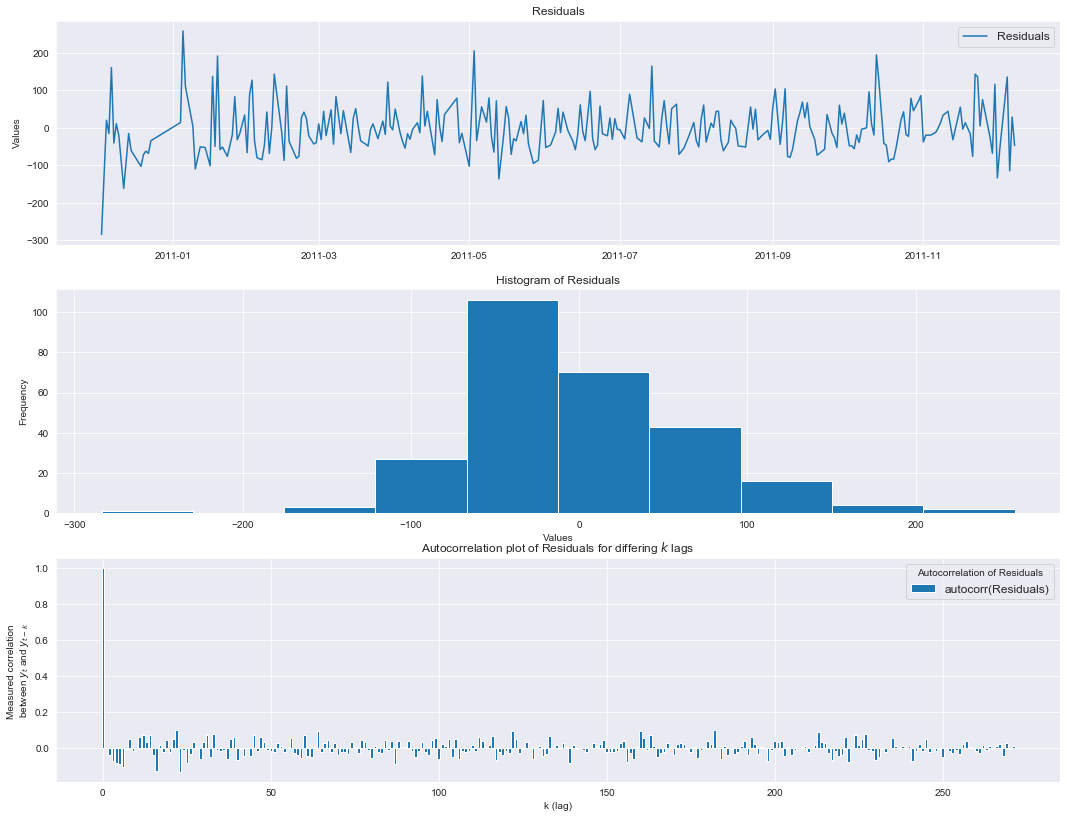

In [28]:
# Plot and investigate the residuals
residuals = pd.DataFrame(results.resid)

x = np.arange(0, len(residuals))

fig, ax = plt.subplots(3, 1, figsize=(18,14))
#ax[0].plot(np.exp(residuals), label='Residuals')
ax[0].plot(residuals, label='Residuals')
ax[0].set_ylabel('Values')
ax[0].set_title('Residuals')
ax[0].legend(fontsize=12)

ax[1].hist(residuals[0])
ax[1].set_xlabel('Values')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Residuals')

#ax[2].bar( x, autocorr(np.exp(residuals[0])) )
ax[2].bar( x, autocorr(residuals[0]), label='autocorr(Residuals)')
ax[2].set_xlabel('k (lag)')
ax[2].set_ylabel('Measured correlation \nbetween $y_t$ and $y_{t-k}$')
ax[2].set_title('Autocorrelation plot of Residuals for differing $k$ lags')
ax[2].legend(title='Autocorrelation of Residuals', fontsize=12);

Above, the residuals and its following autocorrelation plot is visualized above. The residuals don't seem to be autocorrelated and are normally distributed, which is a good sign.

In [29]:
pred = results.predict(start=pd.to_datetime('2011-09-01'),
                       dynamic=False)

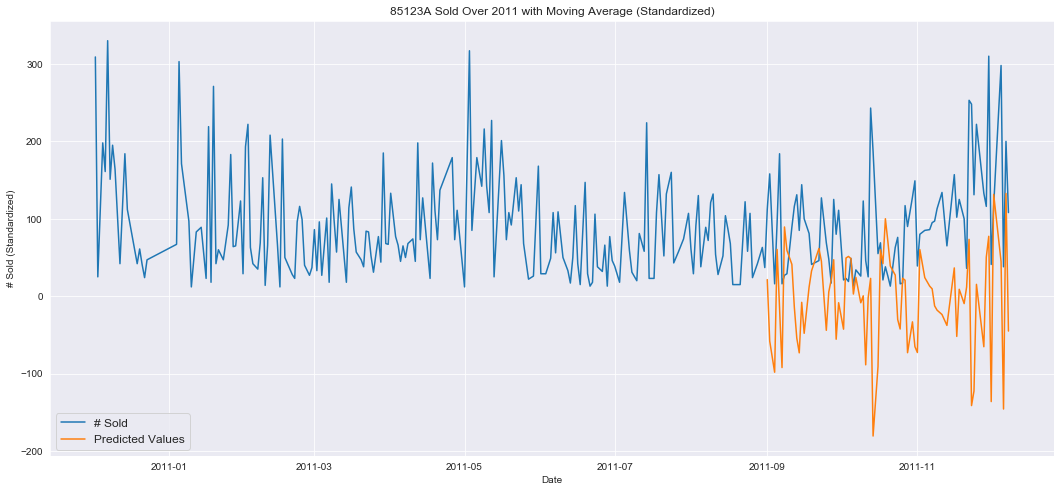

In [30]:
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(t, y, label='# Sold')
ax.plot(pred, label='Predicted Values')

ax.set_xlabel('Date')
ax.set_ylabel('# Sold (Standardized)')
ax.set_title('85123A Sold Over 2011 with Moving Average (Standardized)')
ax.legend(fontsize=12);

This way doesn't look very accurate, let's explore another way.

## 2nd way (with walk forward validation)

https://machinelearningmastery.com/tune-arima-parameters-python/. Jason provides a solution to evaluate the performance of the algorithm using the root-mean-squared (RMSE) metric.

### Recall the distribution of the data is not a normal distribution

ARIMA uses MLE as part of its algorithm, which presupposes that the data comes from a normal distribution.

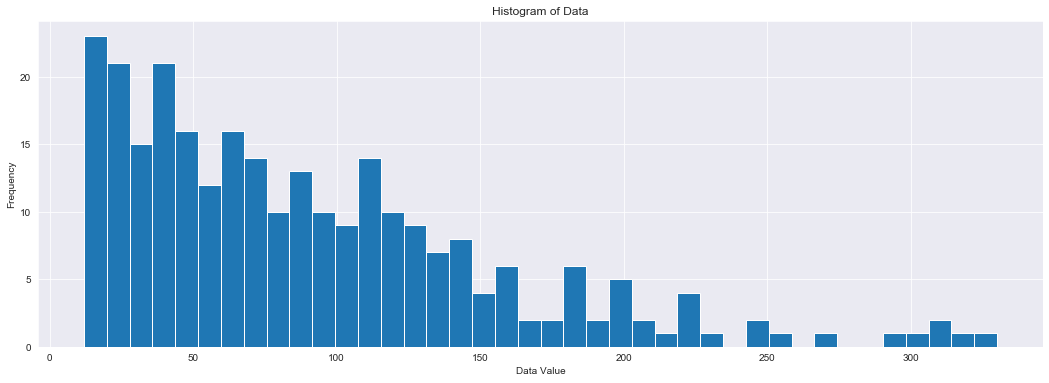

In [72]:
# Plot histogram
fig = plt.figure(figsize=(18,6))

plt.hist(y, bins=40)
plt.xlabel('Data Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data');

### Transform the distribution to a normal distribution by taking the log of the data

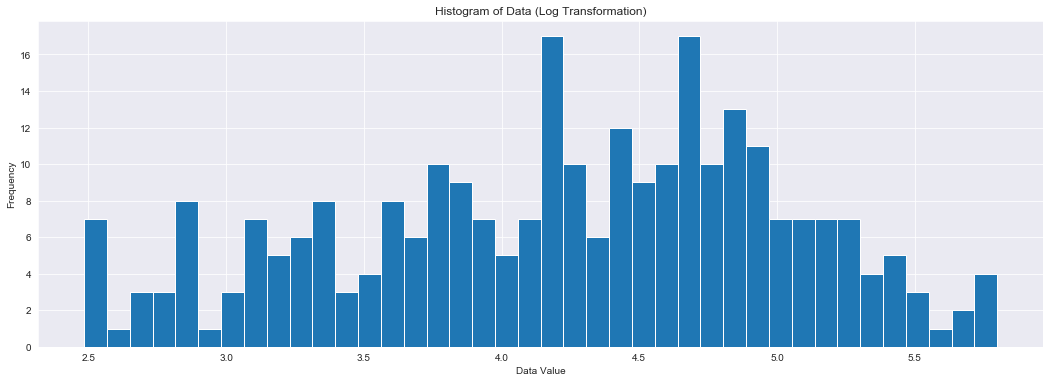

In [73]:
# Take the log of the data
y_log = np.log(y)

# Plot histogram
fig = plt.figure(figsize=(18,6))

plt.hist(np.log(y), bins=40)
plt.xlabel('Data Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data (Log Transformation)');

### Improve the model by taking the log of the data, so the distribution looks gaussian

In [74]:
# Split the data into training and validation sets
train, valid = y_log[:-41], y_log[-41:]      # use 15% of the data as the validation set

In [75]:
history = [value for value in train]
predictions = list()

# Walk forward validation
for t in range(len(valid)):
    # Fit the model
    model = ARIMA(endog=history, order=(4,1,0))
    model_fit = model.fit()
    
    # Make single forecast
    forecast = model_fit.forecast()[0][0]
    
    # Store forecasts and observations
    predictions.append(forecast)
    history.append(valid[t])

# Add time index to predictions
predictions = pd.Series(data=predictions, index=valid.index)

In [76]:
# Evaluate forecasts using RMSE. Take the exponential of the log values to convert the predictions back to normal values
rmse = np.sqrt(mean_squared_error(np.exp(valid), np.exp(predictions)))       
print(f'Root mean squared error = {round(rmse, 2)}')

Root mean squared error = 72.96


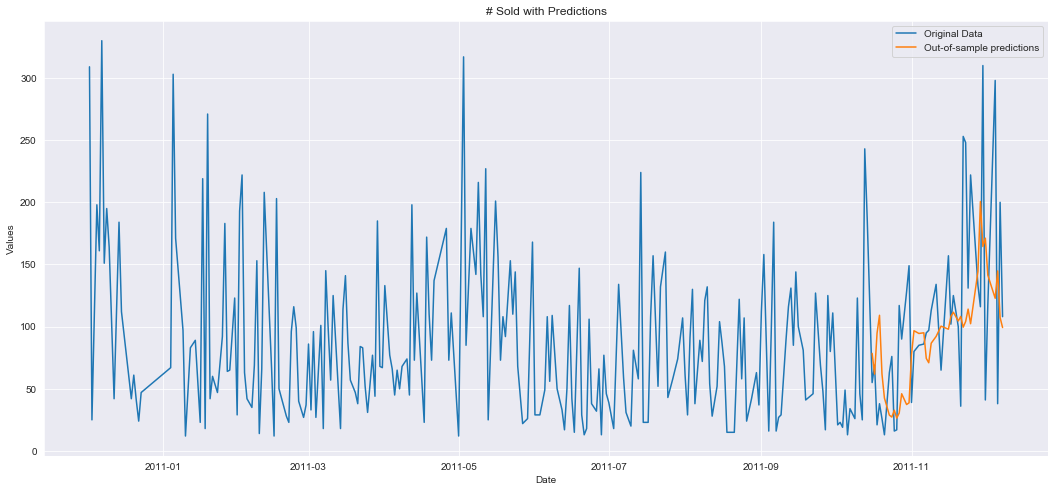

In [77]:
fig, ax = plt.subplots(figsize=(18,8))

ax.plot(y_log.index, np.exp(y_log), label='Original Data')
ax.plot(predictions.index, np.exp(predictions), label='Out-of-sample predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('# Sold with Predictions')
ax.legend();

### Improve the model by tuning the its parameters

When calling the fit() function there are a few parameters to be called:

> 1. disp: True/False. "If True, convergence information is printed. For the default l_bfgs_b solver, disp controls the frequency of the output during the iterations. disp < 0 means no output in this case."

> 2. transparams: True/False. "Whether or not to transform the parameters to ensure stationarity. Uses the transformation suggested in Jones (1980). If False, no checking for stationarity or invertibility is done."

> 3. trend: c/nc. "Whether to include a constant or not. ‘c’ includes constant, ‘nc’ no constant." A bias/intercept term.

> 4. solver: ['lbfgs', 'bfgs', 'newton', 'nm', 'cg', 'ncg', 'powell']. Solver to be used. The default is ‘lbfgs’ (limited memory Broyden-Fletcher-Goldfarb-Shanno). Other choices are ‘bfgs’, ‘newton’ (Newton-Raphson), ‘nm’ (Nelder-Mead), ‘cg’ – (conjugate gradient), ‘ncg’ (non-conjugate gradient), and ‘powell’. By default, the limited memory BFGS uses m=12 to approximate the Hessian, projected gradient tolerance of 1e-8 and factr = 1e2. You can change these by using kwargs.

> Documentation: https://machinelearningmastery.com/tune-arima-parameters-python/

In [78]:
# Split the data into training and validation sets
train, valid = y_log[:-41], y_log[-41:]      # use 15% of the data as the validation set

In [79]:
history = [value for value in train]
predictions = list()

# Walk forward validation
for t in range(len(valid)):
    # Fit the model
    model = ARIMA(endog=history, order=(4,1,0))
    model_fit = model.fit(disp=False, transparams=True, trend='nc', solver='lbfgs')
    
    # Make single forecast
    forecast = model_fit.forecast()[0][0]
    
    # Store forecasts and observations
    predictions.append(forecast)
    history.append(valid[t])    # walk forward 1 step in the validation set and add that data to the history

# Add time index to predictions
predictions = pd.Series(data=predictions, index=valid.index)

In [80]:
# Evaluate forecasts using RMSE. Take the exponential of the log values to convert the predictions back to normal values
rmse = np.sqrt(mean_squared_error(np.exp(valid), np.exp(predictions)))       
print(f'Root mean squared error = {round(rmse, 2)}')

Root mean squared error = 72.83


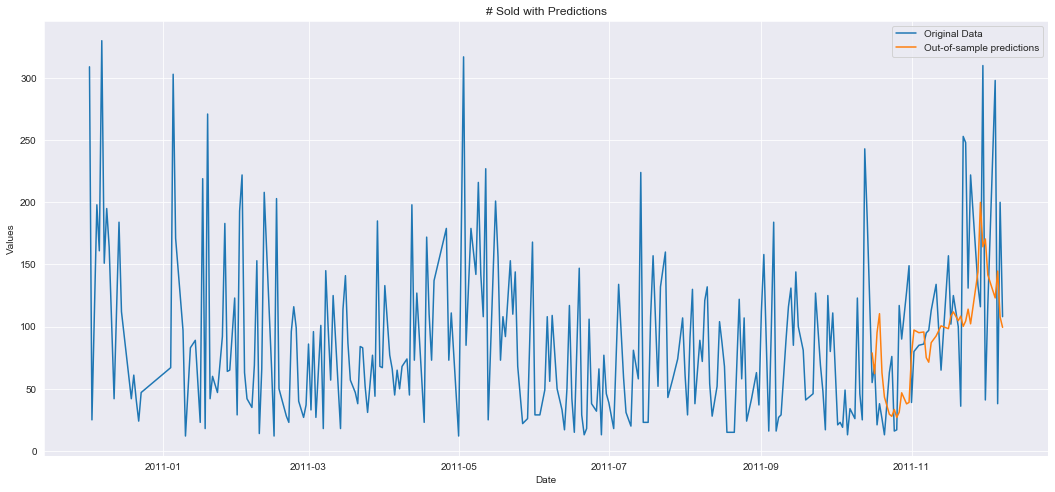

In [81]:
fig, ax = plt.subplots(figsize=(18,8))

ax.plot(y_log.index, np.exp(y_log), label='Original Data')
ax.plot(predictions.index, np.exp(predictions), label='Out-of-sample predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('# Sold with Predictions')
ax.legend();

There is a small improvement to the model's accuracy after tuning the parameters!

### Using the model to predict future sales

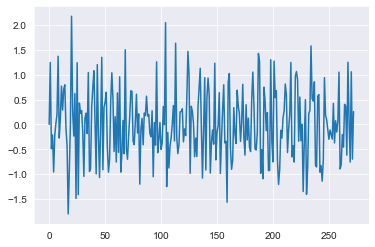

In [82]:
temp = model_fit.predict(1, 273)
plt.plot(temp)

In [59]:
len(y)

273

In [49]:
pd.to_datetime('2012-3-3')

Timestamp('2012-03-03 00:00:00')

## 6. Customer Segmentation & Clustering

Will continue at another time.